## First TradingStrategy class uses a machine learning-based approach to predict stock returns


In [ ]:
class TradingStrategy:
    def __init__(self):
        self.model = LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=42,
            verbose=-1
        )
        self.scaler = StandardScaler()

    def create_features(self, closes: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """Create robust features and target"""
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            returns = closes.pct_change()

            # Target: Next day return > median (more robust than mean)
            # Explicitly align the median Series with the returns DataFrame
            median_returns = returns.median(axis=1)
            y = (returns.shift(-1).gt(median_returns, axis=0)).stack()

            # Feature set
            X = pd.DataFrame()
            for window in [3, 5, 10, 20]:
                X[f'mom_{window}'] = returns.rolling(window).mean().stack()
                X[f'vol_{window}'] = returns.rolling(window).std().stack()
                X[f'zscore_{window}'] = (
                    (closes - closes.rolling(window).mean()) /
                    closes.rolling(window).std()
                ).stack()

            valid_idx = ~X.isna().any(axis=1) & ~y.isna()
            return X[valid_idx], y[valid_idx]

    def train(self, X: pd.DataFrame, y: pd.Series):
        """Train model with error handling"""
        try:
            if len(X) > 100:
                X_scaled = self.scaler.fit_transform(X)
                self.model.fit(X_scaled, y)
        except Exception as e:
            print(f"Training warning: {str(e)}")

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """Generate predictions safely"""
        try:
            X_scaled = self.scaler.transform(X)
            return pd.Series(
                self.model.predict_proba(X_scaled)[:, 1],
                index=X.index
            )
        except:
            return pd.Series(0.5, index=X.index)

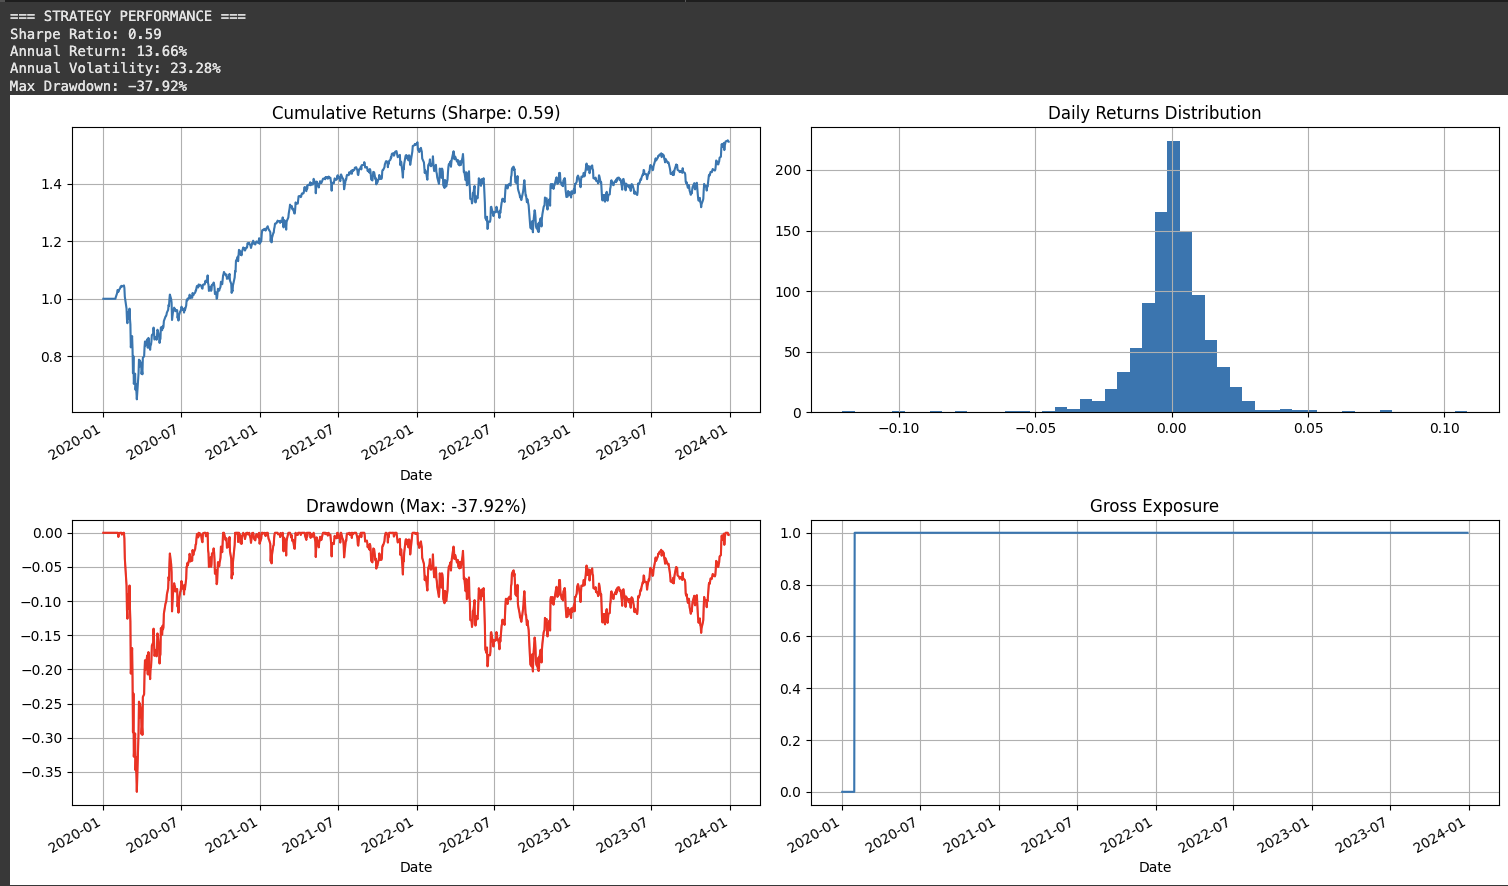

# Bollinger Bands Mean-Reversion Strategy

# This strategy employs a classic technical analysis approach to identify overbought/oversold conditions

In [ ]:
class BollingerBandsStrategy:
    def __init__(self, window=20, num_std=2):
        self.window = window
        self.num_std = num_std

    def generate_signals(self, closes: pd.DataFrame) -> pd.DataFrame:
        """
        Generates mean reversion signals using Bollinger Bands:
        1 when price crosses below lower band (buy)
        -1 when price crosses above upper band (sell)
        0 otherwise (hold)
        """
        signals = pd.DataFrame(index=closes.index, columns=closes.columns)

        for ticker in closes.columns:
            rolling_mean = closes[ticker].rolling(self.window).mean()
            rolling_std = closes[ticker].rolling(self.window).std()

            upper_band = rolling_mean + (rolling_std * self.num_std)
            lower_band = rolling_mean - (rolling_std * self.num_std)

            signals[ticker] = np.where(
                closes[ticker] < lower_band, 1,  # Buy signal
                np.where(
                    closes[ticker] > upper_band, -1,  # Sell signal
                    0  # Neutral
                )
            )

        return signals.shift(1)  # Trade on next day


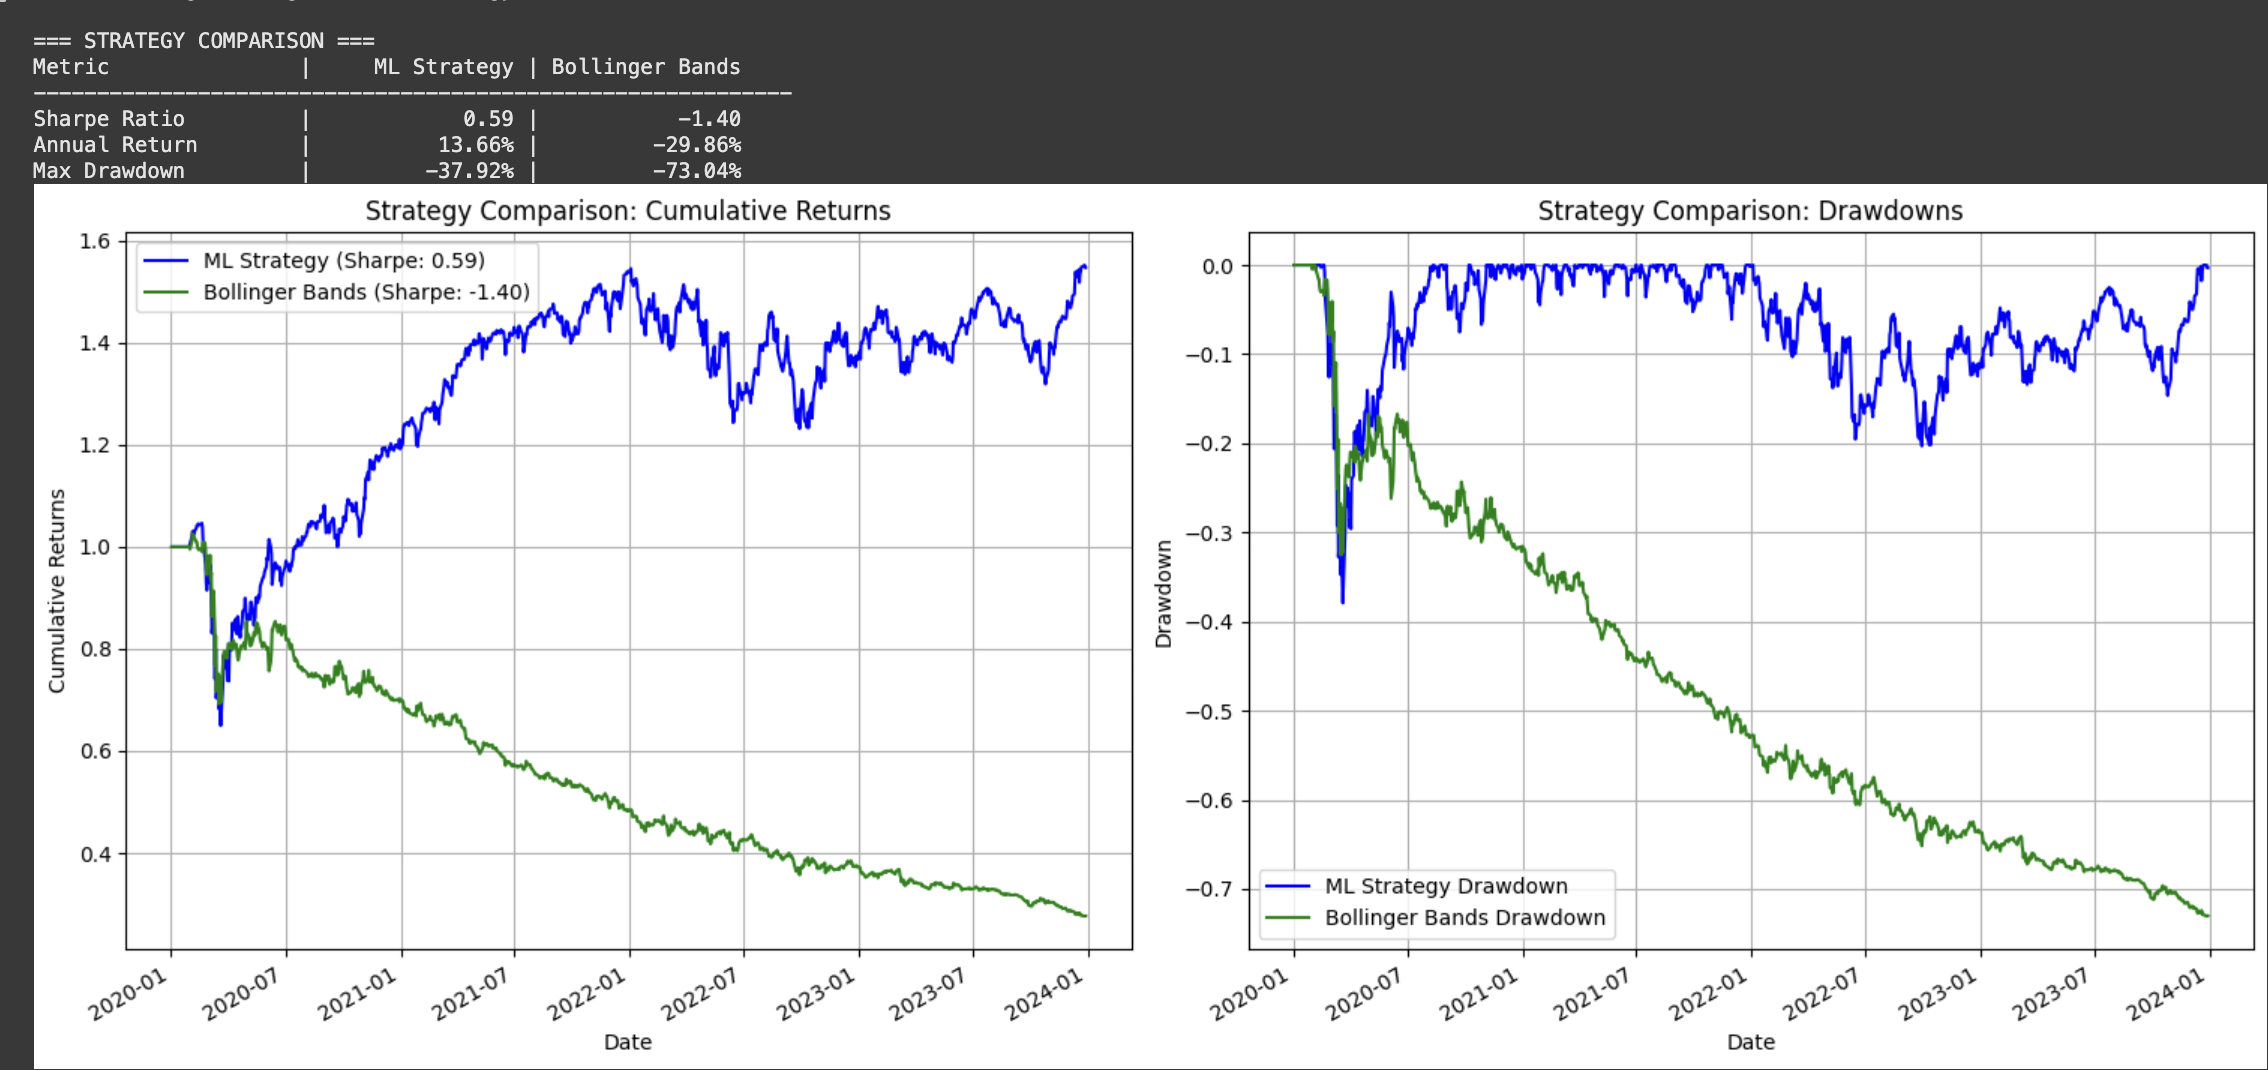

# 3rd Strategy: Dual Moving Average Crossover

In [ ]:
class DualMovingAverageStrategy:
    def __init__(self, short_window=10, long_window=50):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, closes: pd.DataFrame) -> pd.DataFrame:
        """
        Generates trend-following signals:
        1 when short MA > long MA (uptrend)
        -1 when short MA < long MA (downtrend)
        """
        signals = pd.DataFrame(index=closes.index, columns=closes.columns)

        for ticker in closes.columns:
            short_ma = closes[ticker].rolling(self.short_window).mean()
            long_ma = closes[ticker].rolling(self.long_window).mean()

            signals[ticker] = np.where(short_ma > long_ma, 1, -1)

        return signals.shift(1)  # Trade on next day

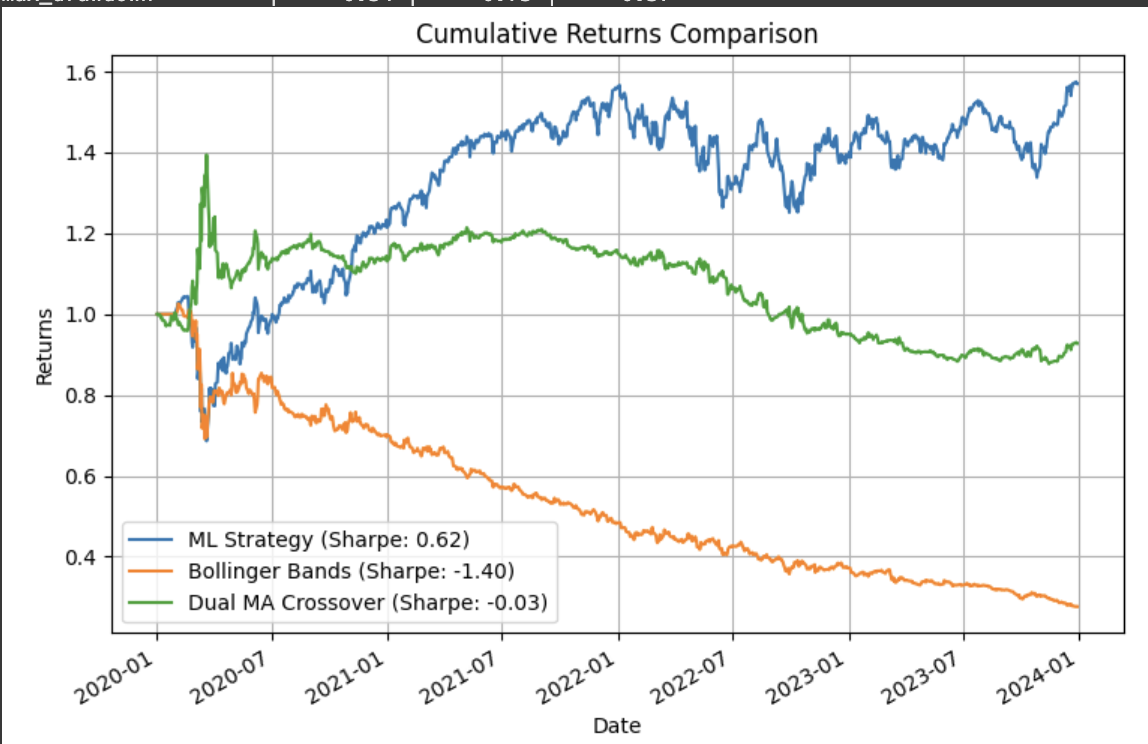